
# Mask on face detection <a class="anchor" id="section_0"></a>

POIDVIN Hugo, LAY Frédéric, NGUYEN VAN NGUYEN Vincent, LECORFF Erwann

This notebook contains a project which aim to detect the presence or not of a face mask on human faces.
The work will take the form of a classification algorithm which will differentiate photos between 2 categories :
-   People wearing a mask
-   People **NOT** wearing a mask


Data from kaggle : [Here](https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset)


### Table of Contents

* [Introduction](#section_0)
* [Imports](#section_1)
* [Sampling](#section_2)
* [Dataset setup](#section_3)
* [Model creation](#section_4)
* [Model training](#section_5)


# Imports <a class="anchor" id="section_1"></a>

In [323]:
import os
from PIL import ImageFont
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16,preprocess_input
from pathlib import Path
import visualkeras
import numpy as np
from numpy.random import randint
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage import rotate

# Sampling <a class="anchor" id="section_2"></a>

initializing paths to our differents images :

In [324]:
#paths initialization
Test_path_Mask = Path("./New Masks Dataset/Test/Mask")
Test_path_Non_Mask = Path("./New Masks Dataset/Test/Non Mask")
Train_path_Mask = Path("./New Masks Dataset/Train/Mask")
Train_path_Non_Mask = Path("./New Masks Dataset/Train/Non Mask")
Validation_path_Mask = Path("./New Masks Dataset/Validation/Mask")
Validation_path_Non_Mask = Path("./New Masks Dataset/Validation/Non Mask")

Collecting 2 photos, one face with mask and one without :

In [325]:
#Collecting one masked face image :
Test_mask_img_list = os.listdir(Test_path_Mask)
masked_image = load_img(str(Test_path_Mask) + "/" + Test_mask_img_list[0])
#Collecting one unmasked face image :
Test_Non_mask_img_list = os.listdir(Test_path_Non_Mask)
Unmasked_image = load_img(str(Test_path_Non_Mask) + "/" + Test_Non_mask_img_list[0])

Showing our 2 pictures :

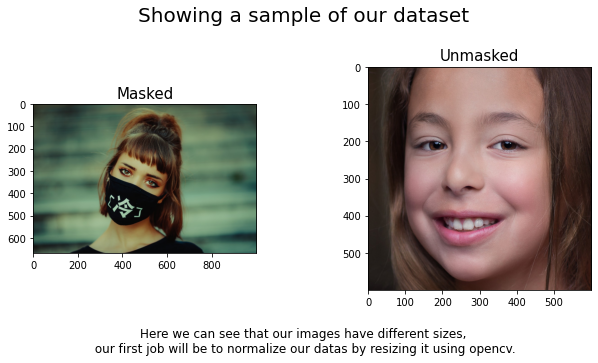

In [326]:
#creating subplot using labels
fig, ax = plt.subplot_mosaic([['Masked', 'Unmasked']], figsize=(10, 5))

ax['Masked'].imshow(masked_image)
ax['Unmasked'].imshow(Unmasked_image)
ax['Masked'].set_title('Masked', fontsize="15")
ax['Unmasked'].set_title('Unmasked', fontsize="15")

fig.suptitle('Showing a sample of our dataset', fontsize="20")
plt.subplots_adjust(wspace=0.5)
fig.supxlabel(
    'Here we can see that our images have different sizes,\n our first job will be to normalize our datas by resizing it using opencv.')
plt.show()

# Dataset setup <a class="anchor" id="section_3"></a>

Checking the actual dataset distribution :

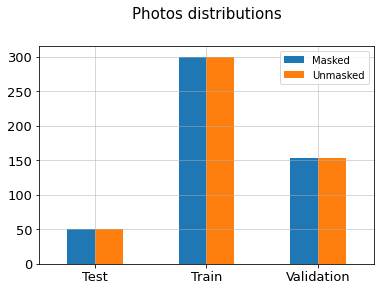

In [327]:
#creating a dict to facilitate the dataframe creation and plotting
data = {'Masked': [len(os.listdir(Test_path_Mask)),
                   len(os.listdir(Train_path_Mask)),
                   len(os.listdir(Validation_path_Mask))],
        'Unmasked': [len(os.listdir(Test_path_Non_Mask)),
                     len(os.listdir(Train_path_Non_Mask)),
                     len(os.listdir(Validation_path_Non_Mask))]}

df = pd.DataFrame(data)
df.index = ['Test', 'Train', 'Validation']
ax = df.plot(kind="bar", fontsize=13)
ax.set_title("Photos distributions", fontsize=15, y=11 / 10)
plt.xticks(rotation=0)
plt.grid(linewidth=0.5)

Initializing our differents sets :

In [328]:
X_train = []
y_train = []
X_test = []
y_test = []
X_valid = []
y_valid = []

dim = 224  # initializing the dimension of our photos, final dimension will be dim*dim, VGG16 default dim is 224*224*3

category = {'Non Mask': 0, 'Mask': 1}  #creating a dict to affect a boolean target to each photo

directory = ["./New Masks Dataset/Train", "./New Masks Dataset/Test", "./New Masks Dataset/Validation"]

for subdirectory in directory :
    for item in os.listdir(subdirectory):  #looping through the subdirectory
        path = os.path.join(subdirectory, item)  #adding "Mask" or "Non Mask" to the subdirectory path
        for image in os.listdir(path):  #looping through "/subdirectory/Mask" then through "/subdirectory/Non Mask"
            img = load_img(os.path.join(path, image), target_size=(dim, dim))
            if subdirectory == "./New Masks Dataset/Train" :
                X_train.append(img)
                y_train.append(category[item])
            elif subdirectory == "./New Masks Dataset/Test" :
                X_test.append(img)
                y_test.append(category[item])
            else :
                X_valid.append(img)
                y_valid.append(category[item])


Showing our 2 modified pictures :

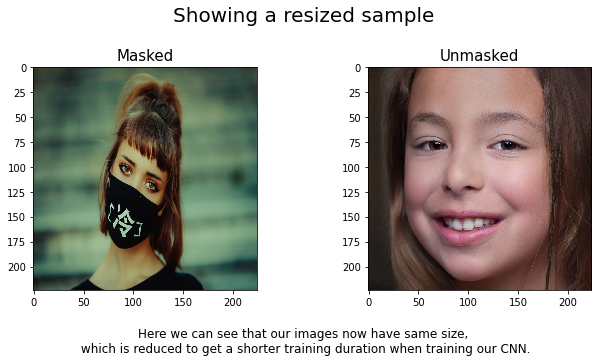

In [329]:
fig, ax = plt.subplot_mosaic([['Masked', 'Unmasked']], figsize=(10, 5))

ax['Masked'].imshow(X_test[0])
ax['Unmasked'].imshow(X_test[50])

ax['Masked'].set_title('Masked', fontsize="15")
ax['Unmasked'].set_title('Unmasked', fontsize="15")

fig.suptitle('Showing a resized sample', fontsize="20")
plt.subplots_adjust(wspace=0.5)
fig.supxlabel(
    'Here we can see that our images now have same size,\n which is reduced to get a shorter training duration when training our CNN.')
plt.show()

Showing our 2 preprocessed pictures :

In [330]:
X_train = list(map(img_to_array,X_train))
X_test = list(map(img_to_array,X_test))
X_valid = list(map(img_to_array,X_valid))

for item in [X_train, X_test, X_valid] :
    item = list(map(preprocess_input, item))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


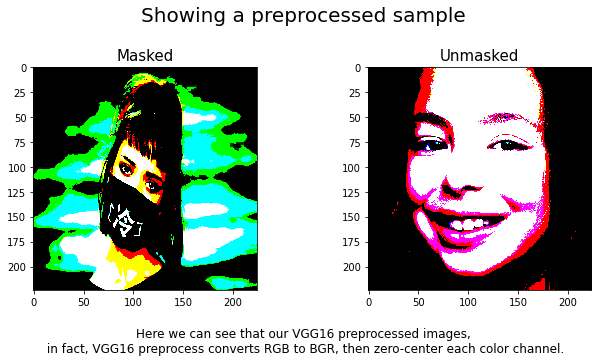

In [331]:
fig, ax = plt.subplot_mosaic([['Masked', 'Unmasked']], figsize=(10, 5))

ax['Masked'].imshow(X_test[0])
ax['Unmasked'].imshow((X_test[50]))

ax['Masked'].set_title('Masked', fontsize="15")
ax['Unmasked'].set_title('Unmasked', fontsize="15")

fig.suptitle('Showing a preprocessed sample', fontsize="20")
plt.subplots_adjust(wspace=0.5)
fig.supxlabel(
    'Here we can see that our VGG16 preprocessed images,\n in fact, VGG16 preprocess converts RGB to BGR, then zero-center each color channel.')
plt.show()

Data augmentation : Rotating image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


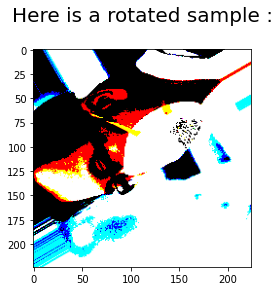

In [332]:
datagen = ImageDataGenerator()
for i in range (X_train.__len__()) :
    image = X_train[i]
    label = y_train[i]
    rotate = datagen.apply_transform(x=image, transform_parameters={'theta' : 120})
    X_train.append(rotate)
    y_train.append(label)
    rotate = datagen.apply_transform(x=image, transform_parameters={'theta' : 240})
    X_train.append(rotate)
    y_train.append(label)

plt.imshow(X_train[601])
plt.title("Here is a rotated sample :\n", fontsize="20")
plt.show()

# Model creation <a class="anchor" id="section_4"></a>

Instancing VGG16 model without output part of the model :

<em>note that we send our resized images shape to the input_shape parameter of VGG16 model</em>

In [333]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(dim, dim, 3))
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Here is a layered representation of our <b> vgg16 base model </b>:

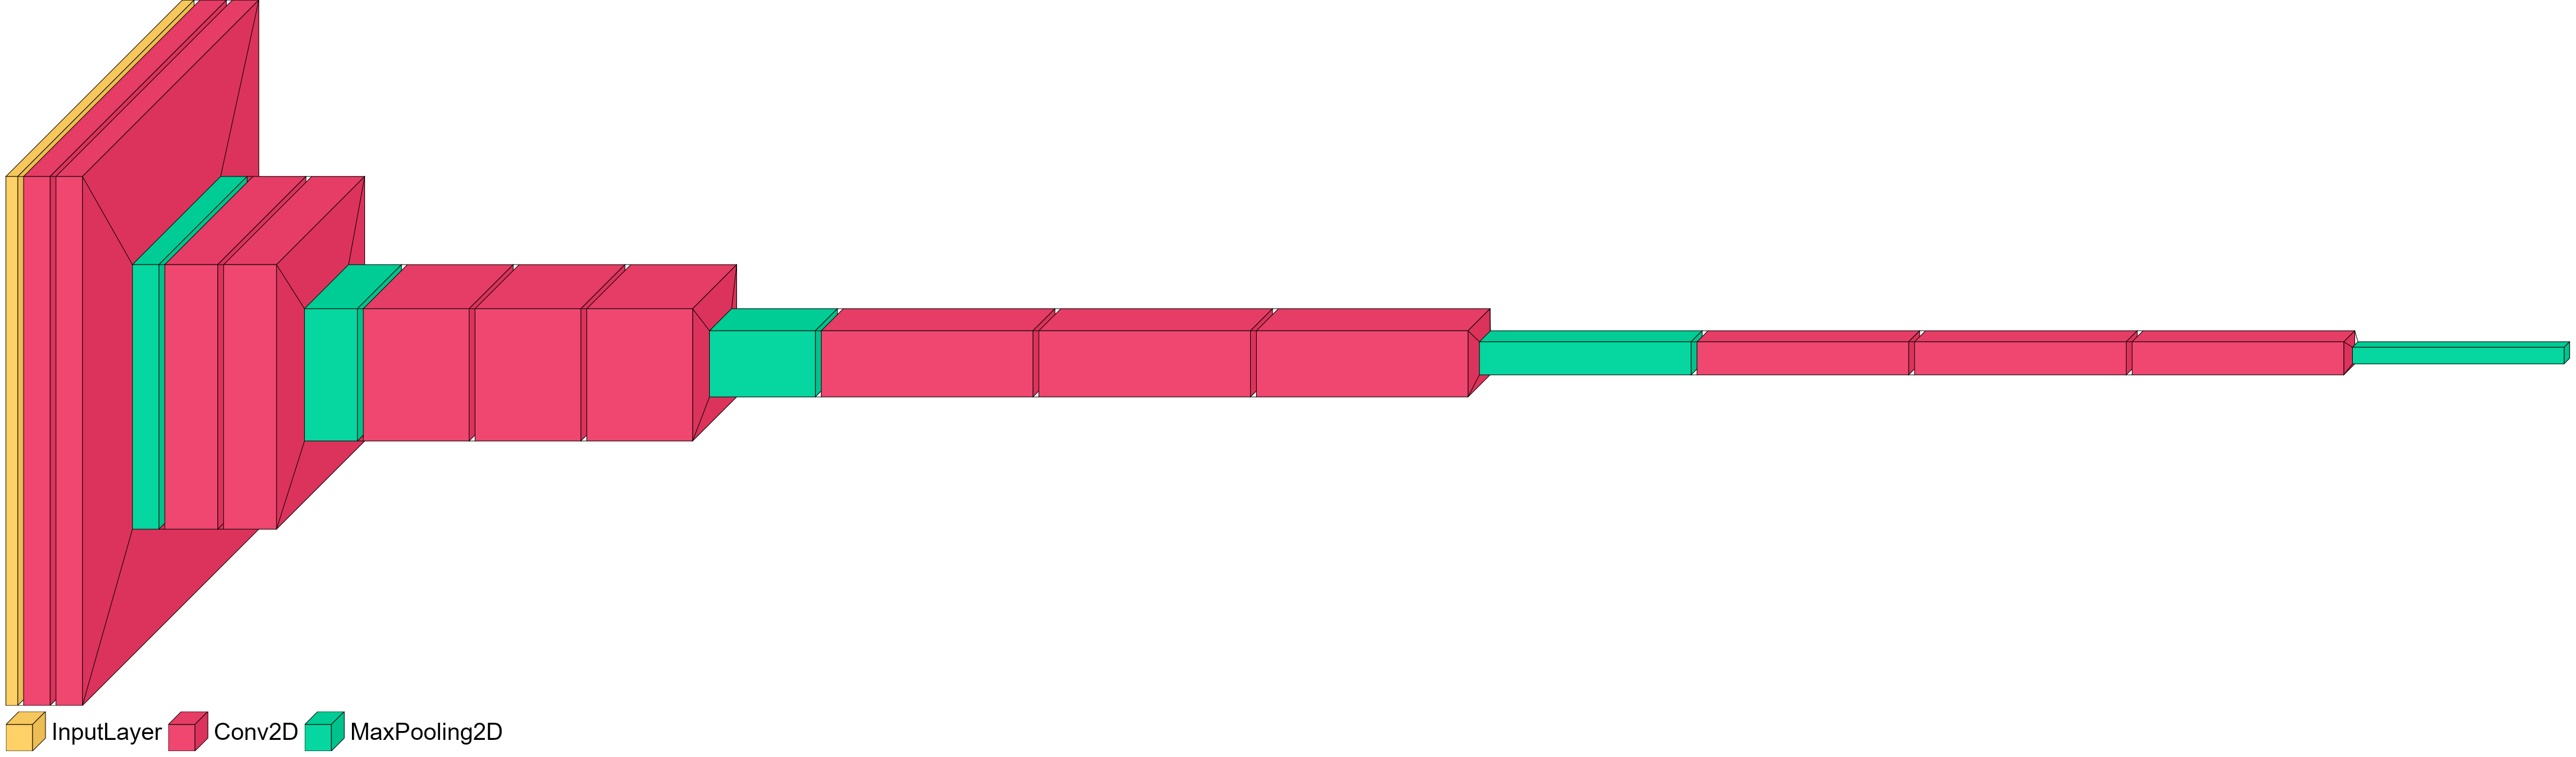

In [334]:
visualkeras.layered_view(vgg16,scale_z=0.7, legend=True, font= (ImageFont.truetype("arial.ttf", 40)))

then we add some layers to finally get our <b> complete model </b> architecture :

<em>note the number of non-trainable params which is equal to vgg16 params number</em>

In [335]:
for layer in vgg16.layers :
    layer.trainable = False

model = Sequential()
model.add(vgg16)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 512)         0         
                                                                 
 flatten_11 (Flatten)        (None, 25088)             0         
                                                                 
 dense_19 (Dense)            (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


# Model training <a class="anchor" id="section_5"></a>

In [336]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [337]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_valid = np.array(y_valid)
X_train = np.array(X_train)
X_test = np.array(X_test)
X_valid = np.array(X_valid)

In [338]:
print("physical devices list : ", tf.config.get_visible_devices())

tf.debugging.set_log_device_placement(True)

physical devices list :  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [339]:
with tf.device('/GPU:0'):
    training = model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_valid, y_valid))

Epoch 1/10
450/450 [==============================] - 15s 32ms/step - loss: 3.2191 - accuracy: 0.8811 - val_loss: 1.9559 - val_accuracy: 0.9314
Epoch 2/10
450/450 [==============================] - 14s 32ms/step - loss: 0.7251 - accuracy: 0.9717 - val_loss: 2.0959 - val_accuracy: 0.9510
Epoch 3/10
450/450 [==============================] - 15s 32ms/step - loss: 1.1214 - accuracy: 0.9667 - val_loss: 1.8949 - val_accuracy: 0.9608
Epoch 4/10
450/450 [==============================] - 15s 33ms/step - loss: 0.5000 - accuracy: 0.9822 - val_loss: 2.3461 - val_accuracy: 0.9575
Epoch 5/10
450/450 [==============================] - 15s 34ms/step - loss: 0.8576 - accuracy: 0.9811 - val_loss: 4.6542 - val_accuracy: 0.9379
Epoch 6/10
450/450 [==============================] - 15s 34ms/step - loss: 0.3507 - accuracy: 0.9872 - val_loss: 2.7326 - val_accuracy: 0.9477
Epoch 7/10
450/450 [==============================] - 16s 35ms/step - loss: 0.5940 - accuracy: 0.9856 - val_loss: 4.1302 - val_accuracy:

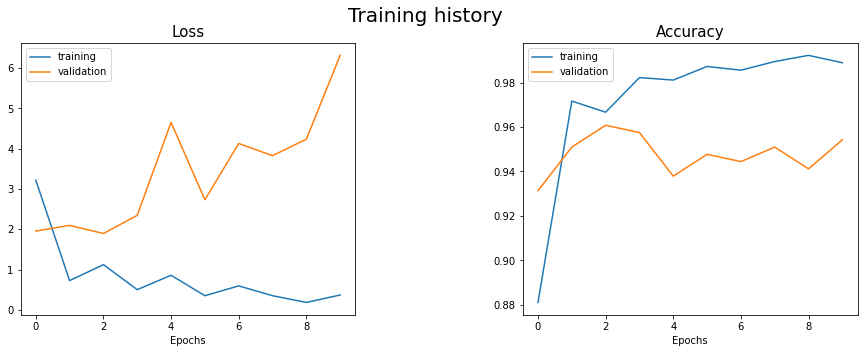

In [340]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))

ax[0].plot(training.history['loss'])
ax[0].plot(training.history['val_loss'])
ax[0].legend(['training','validation'])

ax[1].plot(training.history['accuracy'])
ax[1].plot(training.history['val_accuracy'])
ax[1].legend(['training','validation'])

ax[0].set_title('Loss', fontsize="15")
ax[1].set_title('Accuracy', fontsize="15")
ax[0].set_xlabel("Epochs")
ax[1].set_xlabel("Epochs")

fig.suptitle('Training history', fontsize="20")
plt.subplots_adjust(wspace=0.5)
plt.show()